In [1]:
import findspark
findspark.init()


In [2]:
from pyspark.sql import SparkSession

# Créer une nouvelle session Spark avec l'adresse IP du conteneur
spark = SparkSession.builder \
    .appName("TestLocal") \
    .master("local[*]") \
    .getOrCreate()

# Vérifier la version de Spark
print(spark.version)

3.5.3


In [3]:
import numpy as np
import pandas as pd


In [24]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("PowerConsumption").getOrCreate()

# Charger le fichier texte avec des délimiteurs (par exemple, point-virgule ";")
df = spark.read.csv("household_power_consumption.txt", 
                    header=True, 
                    inferSchema=True, 
                    sep=";")  # Changez delimiter selon le séparateur utilisé

# Afficher les premières lignes
df.show(5)


+----------+-------------------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|      Date|               Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----------+-------------------+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|16/12/2006|2024-12-15 17:24:00|              4.216|                0.418|234.840|          18.400|         0.000|         1.000|          17.0|
|16/12/2006|2024-12-15 17:25:00|              5.360|                0.436|233.630|          23.000|         0.000|         1.000|          16.0|
|16/12/2006|2024-12-15 17:26:00|              5.374|                0.498|233.290|          23.000|         0.000|         2.000|          17.0|
|16/12/2006|2024-12-15 17:27:00|              5.388|                0.502|233.740|          23.000|         0.000|         1.000| 

In [23]:
# Number of rows
num_rows = df.count()

# Number of columns
num_columns = len(df.columns)

# Display the shape
print(f"Shape of DataFrame: ({num_rows}, {num_columns})")


Shape of DataFrame: (2075259, 9)


In [25]:
from pyspark.sql.functions import col

# Convert columns to float
df = df.withColumn('Global_active_power', col('Global_active_power').cast('float')) \
       .withColumn('Global_reactive_power', col('Global_reactive_power').cast('float')) \
       .withColumn('Voltage', col('Voltage').cast('float')) \
       .withColumn('Global_intensity', col('Global_intensity').cast('float')) \
       .withColumn('Sub_metering_1', col('Sub_metering_1').cast('float')) \
       .withColumn('Sub_metering_2', col('Sub_metering_2').cast('float')) \
       .withColumn('Sub_metering_3', col('Sub_metering_3').cast('float'))

# Drop the 'Date' and 'Time' columns
df = df.drop('Date', 'Time')

# Show the DataFrame schema (data types of columns)
df.printSchema()

root
 |-- Global_active_power: float (nullable = true)
 |-- Global_reactive_power: float (nullable = true)
 |-- Voltage: float (nullable = true)
 |-- Global_intensity: float (nullable = true)
 |-- Sub_metering_1: float (nullable = true)
 |-- Sub_metering_2: float (nullable = true)
 |-- Sub_metering_3: float (nullable = true)



In [26]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Select numeric columns
numeric_columns = [col for col, dtype in df.dtypes if dtype in ['float', 'int']]

# Replace missing values in numeric columns with the median
for col in numeric_columns:
    median_value = df.approxQuantile(col, [0.5], 0.0)[0]
    df = df.fillna({col: median_value})

# Check for missing values
missing_values = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_values.show()

# Check column data types
print(df.dtypes)


+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|                  0|                    0|      0|               0|             0|             0|             0|
+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+

[('Global_active_power', 'float'), ('Global_reactive_power', 'float'), ('Voltage', 'float'), ('Global_intensity', 'float'), ('Sub_metering_1', 'float'), ('Sub_metering_2', 'float'), ('Sub_metering_3', 'float')]


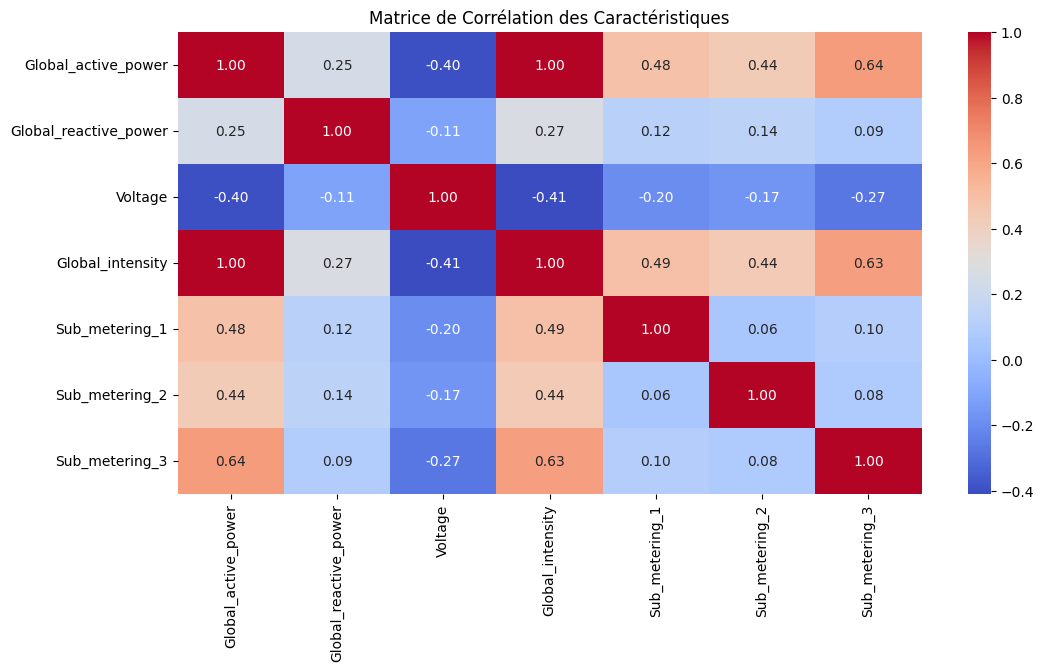

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

#Select numerical columns for correlation (you can modify this list based on your actual column names)
numeric_columns = [col for col, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

# Compute the correlation matrix
corr_matrix = df.select(numeric_columns).toPandas().corr()

# Visualize the correlation matrix using Seaborn
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation des Caractéristiques')
plt.show()

In [ ]:

from pyspark.sql import functions as F
from pyspark.sql.functions import col

# Step 1: Drop unnecessary columns (Global_intensity is removed as per the original code)
df = df.drop('Global_intensity')

# Step 2: Split the data into training and testing datasets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Step 3: Define the feature columns (all columns except for the target column)
feature_columns = [c for c in df.columns if c not in ['Global_active_power']]

# Step 4: Check for missing values in both training and testing datasets
X_train_missing = train_data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in feature_columns])
X_test_missing = test_data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in feature_columns])

# Show missing values count
X_train_missing.show()
X_test_missing.show()

# Step 5: Drop rows with NaN in the training and testing data
train_data_cleaned = train_data.dropna()
test_data_cleaned = test_data.dropna()

# Step 6: Align y_train and y_test with the cleaned data (Global_active_power as the target column)
y_train_cleaned = train_data_cleaned.select('Global_active_power')
y_test_cleaned = test_data_cleaned.select('Global_active_power')


+---------------------+-------+--------------+--------------+--------------+
|Global_reactive_power|Voltage|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+---------------------+-------+--------------+--------------+--------------+
|                    0|      0|             0|             0|             0|
+---------------------+-------+--------------+--------------+--------------+



+---------------------+-------+--------------+--------------+--------------+
|Global_reactive_power|Voltage|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+---------------------+-------+--------------+--------------+--------------+
|                    0|      0|             0|             0|             0|
+---------------------+-------+--------------+--------------+--------------+



In [30]:
from pyspark.ml.feature import StandardScaler, VectorAssembler 

#Step 7: Assemble features into a single vector column for model input
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

train_data_ready = assembler.transform(train_data_cleaned).select('features', 'Global_active_power')
test_data_ready = assembler.transform(test_data_cleaned).select('features', 'Global_active_power')

# Step 8: Feature scaling using StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

scaler_model = scaler.fit(train_data_ready)
train_data_scaled = scaler_model.transform(train_data_ready)
test_data_scaled = scaler_model.transform(test_data_ready)

# Show the prepared data (scaled features)
train_data_scaled.show()
test_data_scaled.show()

# Optional: Verify the schema after processing
train_data_scaled.printSchema()
test_data_scaled.printSchema()

+--------------------+-------------------+--------------------+
|            features|Global_active_power|     scaled_features|
+--------------------+-------------------+--------------------+
|(5,[1],[236.28999...|              0.082|(5,[1],[73.420114...|
|(5,[1],[236.08999...|              0.084|(5,[1],[73.357971...|
|(5,[1],[236.80000...|              0.084|(5,[1],[73.578585...|
|(5,[1],[236.99000...|              0.084|(5,[1],[73.637622...|
|(5,[1],[237.66000...|              0.084|(5,[1],[73.845804...|
|(5,[1],[237.89999...|              0.084|(5,[1],[73.920374...|
|(5,[1],[238.02999...|              0.084|(5,[1],[73.960769...|
|(5,[1],[238.05999...|              0.084|(5,[1],[73.970091...|
|(5,[1],[238.11000...|              0.084|(5,[1],[73.985627...|
|(5,[1],[238.14999...|              0.084|(5,[1],[73.998054...|
|(5,[1],[238.30999...|              0.084|(5,[1],[74.047771...|
|(5,[1],[238.36999...|              0.084|(5,[1],[74.066413...|
|(5,[1],[238.39999...|              0.08

+--------------------+-------------------+--------------------+
|            features|Global_active_power|     scaled_features|
+--------------------+-------------------+--------------------+
|(5,[1],[236.71000...|              0.084|(5,[1],[73.550621...|
|(5,[1],[237.66999...|              0.084|(5,[1],[73.848910...|
|(5,[1],[237.97999...|              0.084|(5,[1],[73.945232...|
|    (5,[1],[238.25])|              0.084|(5,[1],[74.029128...|
|(5,[1],[238.42999...|              0.084|(5,[1],[74.085056...|
|     (5,[1],[238.5])|              0.084|(5,[1],[74.106808...|
|(5,[1],[238.82000...|              0.084|(5,[1],[74.206241...|
|(5,[1],[238.91999...|              0.084|(5,[1],[74.237310...|
|(5,[1],[239.25999...|              0.084|(5,[1],[74.342954...|
|(5,[1],[239.25999...|              0.084|(5,[1],[74.342954...|
|(5,[1],[239.27999...|              0.084|(5,[1],[74.349170...|
|(5,[1],[239.32000...|              0.084|(5,[1],[74.361601...|
|(5,[1],[239.33000...|              0.08

In [31]:
# Enregistrer le modèle scaler dans un répertoire
scaler_model.save("scaler_model")


Linear regression 

In [33]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize the linear regression model
lr = LinearRegression(featuresCol="scaled_features", labelCol="Global_active_power")

# Train the model on the scaled training data
lr_model = lr.fit(train_data_scaled)

# Predict on the scaled test data
predictions = lr_model.transform(test_data_scaled)

# Evaluate the model's performance using MSE (Mean Squared Error)
evaluator_mse = RegressionEvaluator(labelCol="Global_active_power", predictionCol="prediction", metricName="mse")
mse = evaluator_mse.evaluate(predictions)

# Evaluate the model's performance using R² (coefficient of determination)
evaluator_r2 = RegressionEvaluator(labelCol="Global_active_power", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

# Print the evaluation metrics
print(f'MSE: {mse}')
print(f'R²: {r2}')


MSE: 0.28602665827501
R²: 0.742752415932435


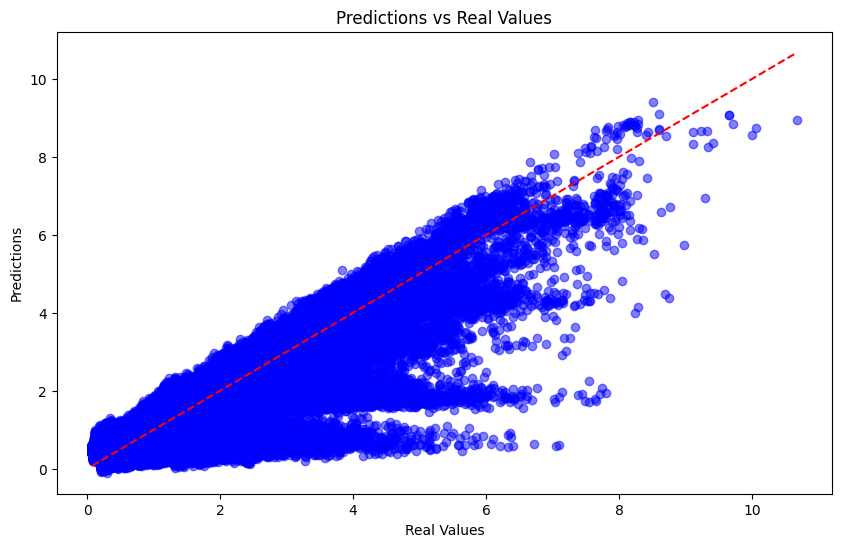

In [34]:
import matplotlib.pyplot as plt

# Extract predictions and real values
predicted_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
real_values = predictions.select("Global_active_power").rdd.flatMap(lambda x: x).collect()

# Visualize predictions vs real values
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predicted_values, alpha=0.5, color='blue')
plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], '--', color='red')  # reference line
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Real Values')
plt.show()


In [35]:
from pyspark.sql.functions import col

# Sauvegarder un modèle PySpark avec la méthode save
lr_model.save("lr_model")



Ng Boost 

In [85]:
print(y_train_cleaned.columns)


['Global_active_power']


In [99]:
X_train_np = np.array(X_train_cleaned.select("scaled_features").rdd.map(lambda row: row[0]).collect())
X_test_np = np.array(X_test_cleaned.select("scaled_features").rdd.map(lambda row: row[0]).collect())

In [106]:
y_train_np = np.array(y_train_cleaned.rdd.map(lambda row: row[0]).collect())

print(X_train_np.shape)  # Should output something like (n_samples, n_features)
print(y_train_np.shape)  # Should output something like (n_samples,)


(1639505, 5)
(1639505,)


In [118]:

# Ensure that `scaled_features` is in the correct format (e.g., a vector)
# Collect the features and target into NumPy arrays
X_train_np = np.array(X_train_cleaned.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
y_train_np = np.array(y_train_cleaned.select("Global_active_power").rdd.map(lambda row: row[0]).collect())

# Make sure the target is 1D
y_train_np = y_train_np.ravel()

# Print the shapes to ensure they are correct
print("Shape of X_train_np:", X_train_np.shape)
print("Shape of y_train_np:", y_train_np.shape)


Shape of X_train_np: (1639505, 5)
Shape of y_train_np: (1639505,)


In [119]:
# Ensure that the number of samples match
assert X_train_np.shape[0] == y_train_np.shape[0], "Mismatch in the number of samples between X and y"



In [120]:
from ngboost import NGBoost
from ngboost.distns import Normal
import numpy as np

# Initialize NGBoost with a normal distribution (for regression)
ngb_model = NGBoost(Dist=Normal)

# Train the NGBoost model using the training data
ngb_model.fit(X_train_np, y_train_np)

# For testing, you can follow a similar process to convert X_test and y_test to NumPy arrays
# Assuming you have a cleaned X_test and y_test Spark DataFrame:
X_test_np = np.array(X_test_cleaned.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
y_test_np = np.array(y_test_cleaned.select("target").rdd.map(lambda row: row[0]).collect())

# Predict the target values using the test data
y_pred = ngb_model.predict(X_test_np)

# The predicted values are stored in y_pred
print("Predicted values:", y_pred)


ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 1639505 is different from 2)

In [115]:
# Collect the features and target into NumPy arrays
X_train_np = np.array(X_train_cleaned.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
y_train_np = np.array(y_train_cleaned.select("target").rdd.map(lambda row: row[0]).collect())

# Make sure the target is 1D
y_train_np = y_train_np.ravel()

# Check the shapes to debug the mismatch
print("Shape of X_train_np:", X_train_np.shape)  # Should be (n_samples, n_features)
print("Shape of y_train_np:", y_train_np.shape)  # Should be (n_samples,)

# Ensure that the number of samples match
assert X_train_np.shape[0] == y_train_np.shape[0], "Mismatch in the number of samples between X and y"


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `target` cannot be resolved. Did you mean one of the following? [`Global_active_power`].;
'Project ['target]
+- Project [Global_active_power#691]
   +- Filter atleastnnonnulls(7, Global_active_power#691, Global_reactive_power#701, Voltage#711, Global_intensity#721, Sub_metering_1#731, Sub_metering_2#741, Sub_metering_3#751)
      +- Sample 0.0, 0.8, false, 42
         +- Sort [Global_active_power#691 ASC NULLS FIRST, Global_reactive_power#701 ASC NULLS FIRST, Voltage#711 ASC NULLS FIRST, Global_intensity#721 ASC NULLS FIRST, Sub_metering_1#731 ASC NULLS FIRST, Sub_metering_2#741 ASC NULLS FIRST, Sub_metering_3#751 ASC NULLS FIRST], false
            +- Project [Global_active_power#691, Global_reactive_power#701, Voltage#711, Global_intensity#721, Sub_metering_1#731, Sub_metering_2#741, Sub_metering_3#751]
               +- Project [Date#503, Time#504, Global_active_power#691, Global_reactive_power#701, Voltage#711, Global_intensity#721, Sub_metering_1#731, Sub_metering_2#741, cast(Sub_metering_3#511 as float) AS Sub_metering_3#751]
                  +- Project [Date#503, Time#504, Global_active_power#691, Global_reactive_power#701, Voltage#711, Global_intensity#721, Sub_metering_1#731, cast(Sub_metering_2#510 as float) AS Sub_metering_2#741, Sub_metering_3#511]
                     +- Project [Date#503, Time#504, Global_active_power#691, Global_reactive_power#701, Voltage#711, Global_intensity#721, cast(Sub_metering_1#509 as float) AS Sub_metering_1#731, Sub_metering_2#510, Sub_metering_3#511]
                        +- Project [Date#503, Time#504, Global_active_power#691, Global_reactive_power#701, Voltage#711, cast(Global_intensity#508 as float) AS Global_intensity#721, Sub_metering_1#509, Sub_metering_2#510, Sub_metering_3#511]
                           +- Project [Date#503, Time#504, Global_active_power#691, Global_reactive_power#701, cast(Voltage#507 as float) AS Voltage#711, Global_intensity#508, Sub_metering_1#509, Sub_metering_2#510, Sub_metering_3#511]
                              +- Project [Date#503, Time#504, Global_active_power#691, cast(Global_reactive_power#506 as float) AS Global_reactive_power#701, Voltage#507, Global_intensity#508, Sub_metering_1#509, Sub_metering_2#510, Sub_metering_3#511]
                                 +- Project [Date#503, Time#504, cast(Global_active_power#505 as float) AS Global_active_power#691, Global_reactive_power#506, Voltage#507, Global_intensity#508, Sub_metering_1#509, Sub_metering_2#510, Sub_metering_3#511]
                                    +- Relation [Date#503,Time#504,Global_active_power#505,Global_reactive_power#506,Voltage#507,Global_intensity#508,Sub_metering_1#509,Sub_metering_2#510,Sub_metering_3#511] csv


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE and R-squared
mse = mean_squared_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


LightGBM


In [121]:
from lightgbm import LGBMRegressor

# Initialize the LightGBM model
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42)

# Train the LightGBM model
lgbm_model.fit(X_train_np, y_train_np)

# To make predictions, similarly convert your test data into NumPy arrays
# Assuming X_test_cleaned and y_test_cleaned are Spark DataFrames
X_test_np = np.array(X_test_cleaned.select("scaled_features").rdd.map(lambda row: row[0].toArray()).collect())
y_test_np = np.array(y_test_cleaned.select("Global_active_power").rdd.map(lambda row: row[0]).collect())

# Make predictions
y_pred = lgbm_model.predict(X_test_np)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 689
[LightGBM] [Info] Number of data points in the train set: 1639505, number of used features: 5
[LightGBM] [Info] Start training from score 1.091265


In [127]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the performance using MSE and R²
lgbm_mse = mean_squared_error(y_test_np, y_pred)
lgbm_r2 = r2_score(y_test_np, y_pred)

# Print the evaluation metrics
print(f'MSE (LightGBM): {lgbm_mse}')
print(f'R² (LightGBM): {lgbm_r2}')

MSE (LightGBM): 0.2570956315158602
R² (LightGBM): 0.7710331737949181


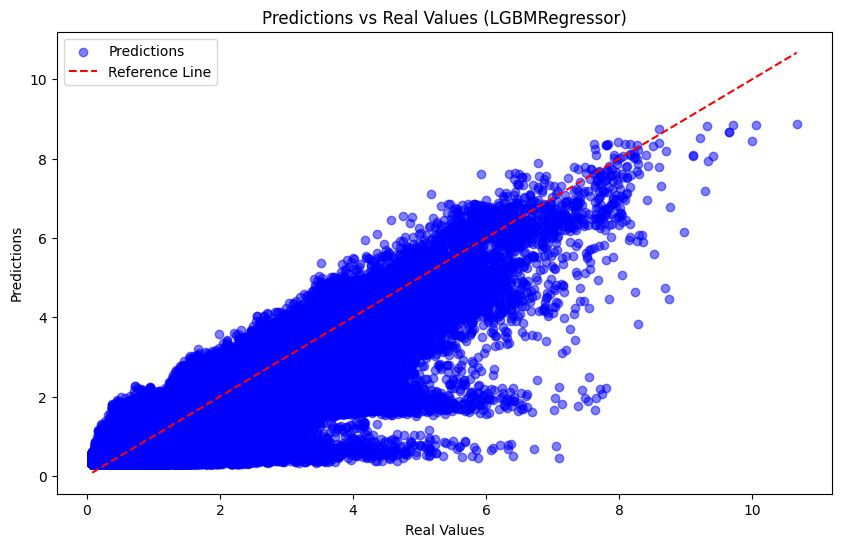

In [129]:
# Visualize predictions vs real values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], '--', color='red', label='Reference Line')  # reference line
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Real Values (LGBMRegressor)')
plt.legend()
plt.show()

In [131]:
import joblib

joblib.dump(lgbm_model, 'lgbm_model.pkl')

['lgbm_model.pkl']